# Downloading of the dataset

--2019-05-31 14:23:50--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2019-05-31 14:25:13--  (try: 2)  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2019-05-31 14:26:36--  (try: 3)  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2019-05-31 14:27:58--  (try: 4)  h

In [ ]:
!tar -xvf VOCtrainval_11-May-2009.tar

VOCdevkit/
VOCdevkit/VOC2009/
VOCdevkit/VOC2009/Annotations/
VOCdevkit/VOC2009/Annotations/2007_000027.xml
VOCdevkit/VOC2009/Annotations/2007_000032.xml
VOCdevkit/VOC2009/Annotations/2007_000033.xml
VOCdevkit/VOC2009/Annotations/2007_000039.xml
VOCdevkit/VOC2009/Annotations/2007_000042.xml
VOCdevkit/VOC2009/Annotations/2007_000061.xml
VOCdevkit/VOC2009/Annotations/2007_000063.xml
VOCdevkit/VOC2009/Annotations/2007_000068.xml
VOCdevkit/VOC2009/Annotations/2007_000121.xml
VOCdevkit/VOC2009/Annotations/2007_000123.xml
VOCdevkit/VOC2009/Annotations/2007_000129.xml
VOCdevkit/VOC2009/Annotations/2007_000170.xml
VOCdevkit/VOC2009/Annotations/2007_000175.xml
VOCdevkit/VOC2009/Annotations/2007_000187.xml
VOCdevkit/VOC2009/Annotations/2007_000241.xml
VOCdevkit/VOC2009/Annotations/2007_000243.xml
VOCdevkit/VOC2009/Annotations/2007_000250.xml
VOCdevkit/VOC2009/Annotations/2007_000256.xml
VOCdevkit/VOC2009/Annotations/2007_000272.xml
VOCdevkit/VOC2009/Annotations/2007_000323.xml
VOCdevkit/VOC2009/A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Loading of the images


In [ ]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
from skimage import util

# parameters that you should set before running this script
filter = [ 'car', 'chair']       # select class, this default should yield 710 training and 688 validation images
voc_root_folder = "VOCdevkit" 
# please replace with the location on your laptop where you unpacked the tarball
image_size = 256    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)


# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]



def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y


x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

# from here, you can start building your model
# you will only need x_train and x_val for the autoencoder
# you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)


XMLSyntaxError: ignored

# 2. AUTOENCODERS

2.2. Non-Linear and Convolutional 



*   Definition of the parameters:



In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D,BatchNormalization, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.optimizers import RMSprop
from keras.regularizers import l2,l1
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# Creating the test set(20% of train set) for training the AE
#x_val,x_test,y_val,y_test = train_test_split(x_val,y_val,test_size=0.2,random_state=13)

# Normalizing the data
#x_test = x_test/x_test.max()
#x_train = x_train/x_train.max()
#x_val = x_val/x_val.max()

batch_size = 32 #using a higher batch size of 256 or 512 is also preferable, depends on the system,
                #It contributes heavily in determining the learning parameters and affects the prediction accuracy
epochs = 50 #train the network for 50 epochs
input_img = Input(shape=(256, 256, 3))


* Encoder

In [ ]:
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img) #(256 x 256 x 8) 8 filters of kernel 3x3
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),padding = 'same')(conv1) #128 x 128 x 8 downsampling
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1) #128 x 128 x 16 16 filters with kernel 3x3
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),padding = 'same')(conv2) #64 x 64 x 16 downsampling
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2) #64 x 64 x 32 (small and thick) 32 filters of 3x3 kernel
conv3 = BatchNormalization()(conv3)
encoded = MaxPooling2D(pool_size=(2, 2),padding = 'same')(conv3) #32 x 32 x 32 downsampling


Instructions for updating:
Colocations handled automatically by placer.


* Decoder

In [ ]:
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded) #32 x 32 x 32 32 filters of 3x3 kernel
conv4 = BatchNormalization()(conv4)
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) #44 x 44 x 128 16 filters of 3x3 kernel
conv5 = BatchNormalization()(conv5)
up2 = UpSampling2D((2,2))(conv5) # 14 x 14 x 128
conv6 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 128 x 128 x 8 8 filters of 3x3 kernel
conv6 = BatchNormalization()(conv6)
decoded = UpSampling2D((2,2))(conv6) # 28 x 28 x 64
#decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) # 256 x 256 x 3  3 filters of 3x3 kernel

#up4 = UpSampling2D((2,2))(conv8) # 28 x 28 x 64
#conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up4) # 176 x 176 x 3  3 filters of 3x3 kernel
#up5 = UpSampling2D((2,2))(conv9) # 28 x 28 x 64
#decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up5) # 176 x 176 x 3  3 filters of 3x3 kernel

autoencoder = Model(input_img, decoded)
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
__________

* Autoencoder

Train on 710 samples, validate on 550 samples
Epoch 1/50
710/710 [==============================] - 13s 18ms/step - loss: 0.0590 - acc: 0.3271 - val_loss: 0.0514 - val_acc: 0.2937
Epoch 2/50
710/710 [==============================] - 5s 7ms/step - loss: 0.0265 - acc: 0.3860 - val_loss: 0.0324 - val_acc: 0.4083
Epoch 3/50
710/710 [==============================] - 5s 7ms/step - loss: 0.0193 - acc: 0.4132 - val_loss: 0.0212 - val_acc: 0.4587
Epoch 4/50
710/710 [==============================] - 5s 7ms/step - loss: 0.0167 - acc: 0.4424 - val_loss: 0.0190 - val_acc: 0.5044
Epoch 5/50
710/710 [==============================] - 5s 7ms/step - loss: 0.0152 - acc: 0.4739 - val_loss: 0.0170 - val_acc: 0.5104
Epoch 6/50
710/710 [==============================] - 5s 7ms/step - loss: 0.0143 - acc: 0.4990 - val_loss: 0.0148 - val_acc: 0.5574
Epoch 7/50
710/710 [==============================] - 5s 7ms/step - loss: 0.0135 - acc: 0.5241 - val_loss: 0.0149 - val_acc: 0.5782
Epoch 8/50
710/710 [========

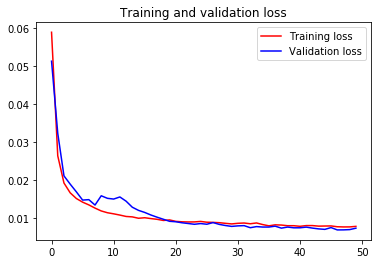

In [ ]:

autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics = ['accuracy']) 


#-----------TRAINING OF THE MODEL----------------------------------------------
autoencoder_train = autoencoder.fit(x_train, x_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, x_val))

#autoencoder_train = autoencoder.fit_generator(datagen.flow(x_train, y_train, batch_size = 32),
                    #steps_per_epoch = len(x_train) / 32, # number of samples per gradient update
                    #epochs = 50, # number of iterations
                    #validation_data= (x_val, x_val),
                    #verbose=1)

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
acc = autoencoder_train.history['acc']
val_acc = autoencoder_train.history['val_acc']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.plot(epochs, acc, 'g', label='Training accuracy')
#plt.plot(epochs, val_acc, 'k', label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()
plt.show()




*   Saving autoencoder weights



In [ ]:
autoencoder.save_weights('autoencoder.h5')



*   Showing the reconstructed images



In [ ]:
reconstructed = autoencoder.predict(x_test)

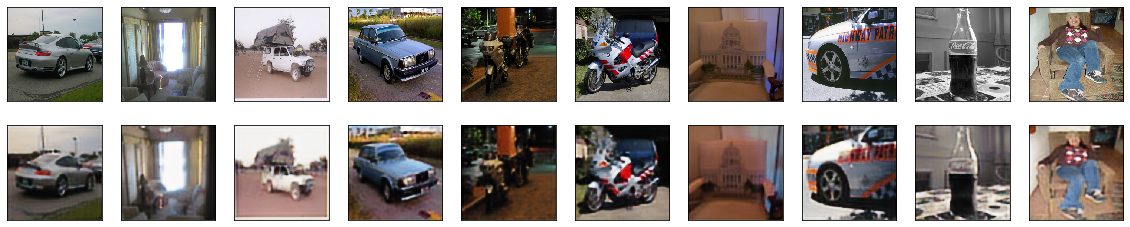

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 3. CLASSIFICATION


*   Fully connected layer: FINE TUNING



In [ ]:
# ----- DEFINING THE FIRST MODEL ----- #

# SO STARTING BY USING THE TRAINED WEIGHTS FROM THE AUTOENCODER AND JUST REMOVING THE DECODER / RECONSTRUCTION LAYERS
#model1 = autoencoder
#for i in range(4) :
 # model1.layer.pop()
  
# AND THEN FREEZING THE LAYERS OF THE ENCODER MODEL
#for layer in model1.layers:
 # layer.trainable = False
#model1 = encoded #layer of the encoding

# THEN ESSENTIALLY ADDING LAYERS FOR FINE TUNING
#model1.add(Dense(64,kernel_initializer='random_normal', activation='relu')(flat))
#model1.add(Dense(2,kernel_initializer='random_normal', activation='softmax')(den))

flat1 = Flatten()(encoded)
den1 = Dense(128, activation = 'relu')(flat1)
out1 = Dense(2, activation = 'softmax')(den1) # 2 because is the number of classes

model1 = Model(input_img,out1)

# ----- DEFINING THE SECOND MODEL ----- #

# INITIALIZING WITH RANDOM WEIGHTS
flat2 = Flatten()(encoded)  
den2 = Dense(128, activation='relu',kernel_initializer='glorot_uniform')(flat2) #,bias_initializer = 'random_uniform')(flat2) #128 or 64, CHECK
out2 = Dense(2, activation='softmax')(den2)
model2 = Model(input_img,out2)









In [ ]:
model1.compile(optimizer='sgd', loss='binary_crossentropy',metrics = ['accuracy'])
model2.compile(optimizer='sgd', loss='binary_crossentropy',metrics = ['accuracy'])


In [ ]:
model1.summary()
model2.summary()

In [ ]:
classify_train1 = model1.fit(x_train, y_train, batch_size=64,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 710 samples, validate on 550 samples
Epoch 1/50
710/710 [==============================] - 12s 16ms/step - loss: 0.6876 - acc: 0.8493 - val_loss: 0.8833 - val_acc: 0.6664
Epoch 2/50
710/710 [==============================] - 2s 3ms/step - loss: 0.1652 - acc: 0.9507 - val_loss: 0.7543 - val_acc: 0.7427
Epoch 3/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0656 - acc: 0.9817 - val_loss: 1.0704 - val_acc: 0.6991
Epoch 4/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0614 - acc: 0.9845 - val_loss: 1.3597 - val_acc: 0.6118
Epoch 5/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0777 - acc: 0.9775 - val_loss: 1.3413 - val_acc: 0.6609
Epoch 6/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0772 - acc: 0.9789 - val_loss: 0.8164 - val_acc: 0.7445
Epoch 7/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0287 - acc: 0.9915 - val_loss: 0.9337 - val_acc: 0.7445
Epoch 8/50
710/710 [========

In [ ]:
#------- EVALUEATE MODEL 1 ---------#

model1_train_scores = model1.evaluate(x_train, y_train)
print("\n%s: %.2f%%" % (model1.metrics_names[1], model1_train_scores[1]*100))

model1_test_scores = model1.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model1.metrics_names[1], model1_test_scores[1]*100))



710/710 [==============================] - 1s 1ms/step

acc: 99.15%
138/138 [==============================] - 0s 1ms/step

acc: 75.72%


In [ ]:
#------- TRAIN MODEL 2 ---------#
classify_train2 = model2.fit(x_train, y_train, batch_size=64,epochs=50,verbose=1,validation_data=(x_val, y_val))





Train on 710 samples, validate on 550 samples
Epoch 1/50
710/710 [==============================] - 12s 17ms/step - loss: 0.4626 - acc: 0.8873 - val_loss: 0.7233 - val_acc: 0.7464
Epoch 2/50
710/710 [==============================] - 2s 3ms/step - loss: 0.1496 - acc: 0.9577 - val_loss: 0.9902 - val_acc: 0.6573
Epoch 3/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0992 - acc: 0.9690 - val_loss: 0.7740 - val_acc: 0.7573
Epoch 4/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0443 - acc: 0.9887 - val_loss: 1.5240 - val_acc: 0.6336
Epoch 5/50
710/710 [==============================] - 2s 3ms/step - loss: 0.1215 - acc: 0.9634 - val_loss: 0.8149 - val_acc: 0.7264
Epoch 6/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0337 - acc: 0.9915 - val_loss: 0.8383 - val_acc: 0.7282
Epoch 7/50
710/710 [==============================] - 2s 3ms/step - loss: 0.0244 - acc: 0.9915 - val_loss: 0.8124 - val_acc: 0.7355
Epoch 8/50
710/710 [========

In [ ]:
#------- EVALUEATE MODEL 2 ---------#

model2_train_scores = model2.evaluate(x_train, y_train)
print("\n%s: %.2f%%" % (model2.metrics_names[1], model2_train_scores[1]*100))

model2_test_scores = model2.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model2.metrics_names[1], model2_test_scores[1]*100))

710/710 [==============================] - 1s 1ms/step

acc: 99.15%
138/138 [==============================] - 0s 1ms/step

acc: 76.45%


In [ ]:
#---------PREDICT LABELS--------#
predicted_classes = model2.predict(x_test)
predicted_classes = np.round(predicted_classes)
predicted_classes.shape

   


(138, 2)

In [ ]:
correct = 0
incorrect = 0
for i in range(np.size(predicted_classes,axis = 0)):
  if (predicted_classes[i,:]==y_test[i,:]).all():
    correct = correct + 1
  else:
    incorrect = incorrect + 1

print ("Found %d incorrect labels" %incorrect)
print ("Found %d correct labels" %correct)



Found 33 incorrect labels
Found 105 correct labels


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class Car", "Class Chair"]
print(classification_report(y_test, predicted_classes,target_names = target_names))

              precision    recall  f1-score   support

   Class Car       0.80      0.77      0.79        79
 Class Chair       0.73      0.75      0.74        60

   micro avg       0.77      0.76      0.77       139
   macro avg       0.76      0.76      0.76       139
weighted avg       0.77      0.76      0.77       139
 samples avg       0.77      0.76      0.77       139



# 4. SEGMENTATION


In [ ]:
from PIL import Image

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Segmentation/")
classes_files = os.listdir(classes_folder)
train_seg_files = [os.path.join(classes_folder, "train.txt")] 
val_seg_files = [os.path.join(classes_folder,"val.txt")] 

def build_segmentation_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    line = []
    fin = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            
    for i in range(np.size(lines)):
        if lines[i] in filtered_filenames:
            line = lines[i]
            fin.append(line)

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = []
    for i in range(np.size(fin)):
        pth = os.path.join(image_folder, fin[i]+".jpg")
        image_filenames.append(pth)
   
    label_folder = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/")
    label_filenames = []
    for i in range(np.size(fin)):
        pth = os.path.join(label_folder, fin[i]+".png")
        label_filenames.append(pth)
    
    
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    y = []

    for i in range(len(x)):
        img = Image.open(label_filenames[i])
        img = img.convert('RGB')
        img.save("VOCdevkit/VOC2009/SegmentationClass/" + fin[i] + ".jpg")
        img = np.array([resize(io.imread("VOCdevkit/VOC2009/SegmentationClass/" + fin[i] + ".jpg"), (image_size, image_size, 3))]).astype('float32') 
        img.resize(image_size, image_size, 3)
        
        y.append(img)
    
    y = np.stack(y,axis = 0)  


    return x, y

x_train_seg, y_train_seg = build_segmentation_dataset(train_seg_files)
print('%i training images' %(x_train_seg.shape[0]))
x_val_seg, y_val_seg = build_segmentation_dataset(val_seg_files)
print('%i validation images' %(x_val_seg.shape[0]))

  



132 training images
106 validation images




*  Selecting test dataset



In [ ]:
x_val_seg,x_test_seg,y_val_seg,y_test_seg = train_test_split(x_val_seg,y_val_seg,test_size=0.2,random_state=13)

# Normalizing the data
x_test_seg = x_test_seg/x_test_seg.max()
x_train_seg = x_train_seg/x_train_seg.max()
x_val_seg = x_val_seg/x_val_seg.max()

print (y_val_seg.shape,y_test_seg.shape)

(84, 256, 256, 3) (22, 256, 256, 3)



  

*   Segmenting the y images






In [ ]:
def segmenting(y_train):
  color = np.array([0.7411765 , 0.        , 0.00737592],dtype = "float32")
  y_seg = []
  for i in range(len(y_train)):
    y = []
    y  = y_train[i]>0
    y = util.img_as_float32(y)
    y = y * color

    y_seg.append(y) 
  
  y_seg = np.stack(y_seg,axis = 0)

  return y_seg
    


In [ ]:
y_training_seg = segmenting(y_train_seg)
y_validating_seg = segmenting(y_val_seg)
y_testing_seg  = segmenting(y_test_seg)



*   Encoder for segmentation



In [ ]:
epochs = 50
input_img = Input(shape=(256, 256, 3))

conv1_seg = Conv2D(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_img)
conv1_seg = Conv2D(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_seg)
#conv1_seg = BatchNormalization()(conv1_seg)
pool1_seg = MaxPooling2D(pool_size=(2, 2),padding = 'same')(conv1_seg)
conv2_seg = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1_seg)
conv2_seg = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_seg)
#conv2_seg = BatchNormalization()(conv2_seg)
pool2_seg = MaxPooling2D(pool_size=(2, 2),padding = 'same')(conv2_seg)
conv3_seg = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2_seg)
conv3_seg = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_seg)
#conv3_seg = BatchNormalization()(conv3_seg)
pool3_seg = MaxPooling2D(pool_size=(2, 2),padding = 'same')(conv3_seg)
conv4_seg = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3_seg)
conv4_seg = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_seg)
#conv4_seg = BatchNormalization()(conv4_seg)
drop4_seg = Dropout(0.5)(conv4_seg)
encoded_seg = MaxPooling2D(pool_size=(2, 2),padding = 'same')(drop4_seg)




*   Decoder



In [ ]:
from keras.layers import concatenate

conv5_seg = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(encoded_seg)
conv5_seg = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5_seg)
#conv5_seg = BatchNormalization()(conv5_seg)
drop5_seg = Dropout(0.5)(conv5_seg)

up6_seg = UpSampling2D((2,2))(drop5_seg) 
merge6_seg = concatenate([conv4_seg,up6_seg], axis = 3)
conv6_seg = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6_seg)
conv6_seg = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6_seg)
#conv6_seg = BatchNormalization()(conv6_seg)

up7_seg = UpSampling2D((2,2))(conv6_seg) 
merge7_seg = concatenate([conv3_seg,up7_seg], axis = 3)
conv7_seg = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7_seg)
conv7_seg = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7_seg)
#conv7_seg = BatchNormalization()(conv7_seg)

up8_seg = UpSampling2D((2,2))(conv7_seg) 
merge8_seg = concatenate([conv2_seg,up8_seg], axis = 3)
conv8_seg = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8_seg)
conv8_seg = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8_seg)
#conv8_seg = BatchNormalization()(conv8_seg)

up9_seg = UpSampling2D((2,2))(conv8_seg) 
merge9_seg = concatenate([conv1_seg,up9_seg], axis = 3)
conv9_seg = Conv2D(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9_seg)
conv9_seg = Conv2D(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9_seg)
decoded_seg = Conv2D(3, (1, 1), activation = 'sigmoid')(conv9_seg)

seg_autoencoder = Model(input_img, decoded_seg)
seg_autoencoder.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 256, 256, 8)  224         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_199 (Conv2D)             (None, 256, 256, 8)  584         conv2d_198[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_199[0][0]                 
__________________________________________________________________________________________________
conv2d_200

In [ ]:
seg_autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy']) 
autoencoder_seg_train = seg_autoencoder.fit(x_train_seg, y_training_seg, batch_size=batch_size,epochs=40,verbose=1,validation_data=(x_val_seg, y_validating_seg))




Train on 132 samples, validate on 84 samples
Epoch 1/40
132/132 [==============================] - 21s 160ms/step - loss: 0.7773 - acc: 0.7859 - val_loss: 1.0240 - val_acc: 0.7461
Epoch 2/40
132/132 [==============================] - 2s 16ms/step - loss: 0.4567 - acc: 0.7952 - val_loss: 0.5236 - val_acc: 0.7182
Epoch 3/40
132/132 [==============================] - 2s 16ms/step - loss: 0.2237 - acc: 0.7730 - val_loss: 0.2669 - val_acc: 0.7371
Epoch 4/40
132/132 [==============================] - 2s 16ms/step - loss: 0.1473 - acc: 0.7852 - val_loss: 0.2120 - val_acc: 0.7294
Epoch 5/40
132/132 [==============================] - 2s 16ms/step - loss: 0.1204 - acc: 0.7854 - val_loss: 0.1977 - val_acc: 0.7395
Epoch 6/40
132/132 [==============================] - 2s 16ms/step - loss: 0.1120 - acc: 0.7922 - val_loss: 0.1998 - val_acc: 0.7469
Epoch 7/40
132/132 [==============================] - 2s 16ms/step - loss: 0.1081 - acc: 0.7926 - val_loss: 0.1880 - val_acc: 0.7382
Epoch 8/40
132/132 [==

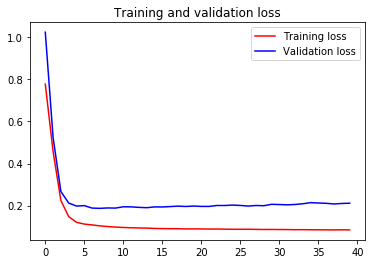

In [ ]:
loss_seg = autoencoder_seg_train.history['loss']
val_loss_seg = autoencoder_seg_train.history['val_loss']
acc_seg = autoencoder_seg_train.history['acc']
val_acc_seg = autoencoder_seg_train.history['val_acc']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss_seg, 'r', label='Training loss')
plt.plot(epochs, val_loss_seg, 'b', label='Validation loss')
#plt.plot(epochs, acc, 'g', label='Training accuracy')
#plt.plot(epochs, val_acc, 'k', label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
seg_autoencoder.save_weights('seg_autoencoder3.h5')

In [ ]:
reconstructed_seg = seg_autoencoder.predict(x_test_seg)

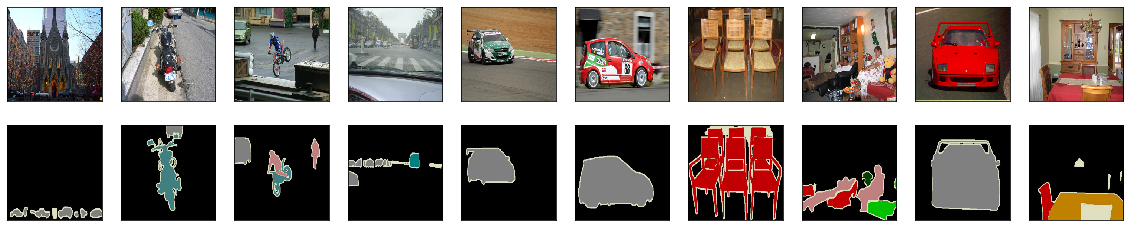

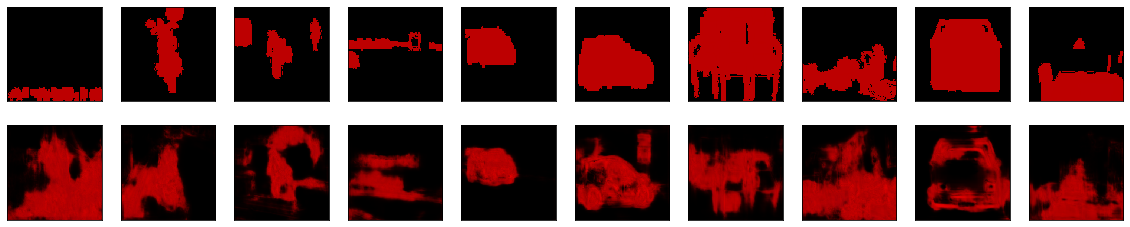

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_seg[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_test_seg[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(y_testing_seg[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_seg[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [ ]:

from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

dice_AE = seg_autoencoder
dice_AE.compile(optimizer='adam', loss= dice_coef_loss, metrics=[dice_coef])
dice_coeff = dice_AE.fit(x_train_seg, y_training_seg, batch_size=batch_size,epochs=40,verbose=1,validation_data=(x_val_seg, y_validating_seg))



Train on 132 samples, validate on 84 samples
Epoch 1/40
132/132 [==============================] - 21s 161ms/step - loss: 0.3081 - dice_coef: 0.6919 - val_loss: 0.4776 - val_dice_coef: 0.5224
Epoch 2/40
132/132 [==============================] - 2s 14ms/step - loss: 0.2455 - dice_coef: 0.7545 - val_loss: 0.5208 - val_dice_coef: 0.4792
Epoch 3/40
132/132 [==============================] - 2s 14ms/step - loss: 0.2420 - dice_coef: 0.7580 - val_loss: 0.4937 - val_dice_coef: 0.5063
Epoch 4/40
132/132 [==============================] - 2s 14ms/step - loss: 0.2393 - dice_coef: 0.7607 - val_loss: 0.4888 - val_dice_coef: 0.5112
Epoch 5/40
132/132 [==============================] - 2s 14ms/step - loss: 0.2346 - dice_coef: 0.7654 - val_loss: 0.4987 - val_dice_coef: 0.5013
Epoch 6/40
132/132 [==============================] - 2s 14ms/step - loss: 0.2254 - dice_coef: 0.7746 - val_loss: 0.4884 - val_dice_coef: 0.5116
Epoch 7/40
132/132 [==============================] - 2s 14ms/step - loss: 0.2222 -

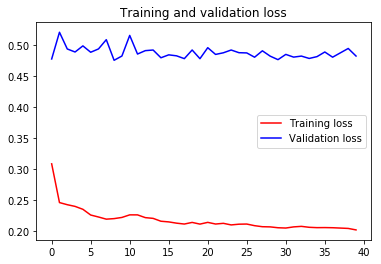

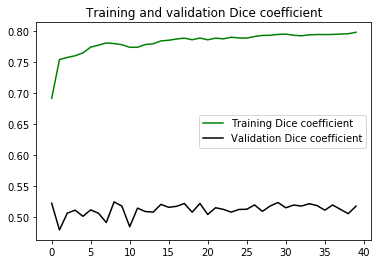

In [ ]:
loss_seg = dice_coeff.history['loss']
val_loss_seg = dice_coeff.history['val_loss']
dc = dice_coeff.history['dice_coef']
dc_val = dice_coeff.history['val_dice_coef']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss_seg, 'r', label='Training loss')
plt.plot(epochs, val_loss_seg, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, dc, 'g', label='Training Dice coefficient')
plt.plot(epochs, dc_val, 'k', label='Validation Dice coefficient')
plt.title('Training and validation Dice coefficient')
plt.legend()
plt.show()

In [ ]:
reconstructed_dice = dice_AE.predict(x_test_seg)

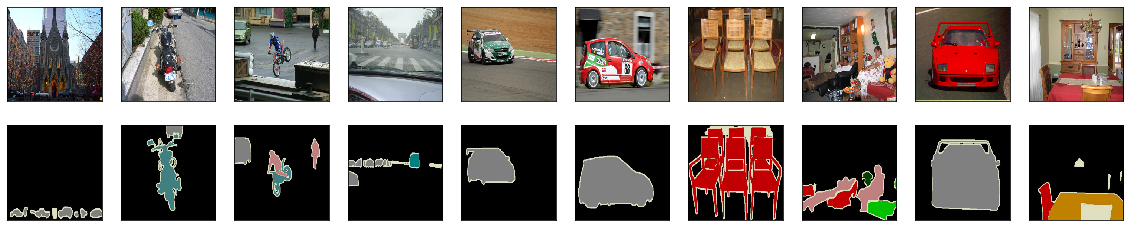

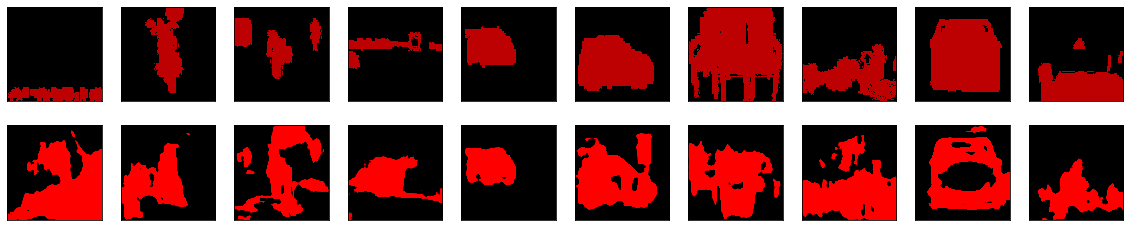

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_seg[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_test_seg[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(y_testing_seg[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_dice[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()